# Experimental validation of the learned emotions

**I. Emotional attribution test with humans**

Verify the distinguishability and correspondence of the learned emotions with independent human observations.

1. Select a representative list of sequences.
2. Gather and validate human feedback for each of the sequences.
3. Verify distinguishability of emotions across participants.
4. Analyze the values obtained for Pleasure / Arousal / Dominance on each emotion.

**II. Mapping PAD values to referenced PAD values**

Map the distribution of PAD values obtained for each learned emotion vs select pivotal experimental findings in psychology literature.

## Dependencies

In [1]:
# The following code was run on Python 3.9.7

In [2]:
# Installation of libraries (in the specific versions used).
%pip install numpy==1.22.2
%pip install pandas==1.4.1
%pip install matplotlib==3.1.1
%pip install seaborn==0.12.2

%pip install statsmodels==0.14.0
%pip install scipy==1.8.0
%pip install pingouin==0.5.3

  Using cached numpy-1.22.2-cp39-cp39-macosx_10_14_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2024.2.0 requires numpy>=1.23, but you have numpy 1.22.2 which is incompatible.
xarray 2024.2.0 requires pandas>=1.5, but you have pandas 1.4.1 which is incompatible.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/Alberto/Code/love-emotional-framework/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consi

In [3]:
# Enable automatic reloading of external modules before executing code here.
%load_ext autoreload
%autoreload 2

In [4]:
# Import packages.
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'; disable warning when copying a slice of a dataframe.

import numpy as np
from numpy import random
import statsmodels.api as sm
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
import pingouin as pg
from scipy.stats import f
from scipy.stats import kstwobign, pearsonr

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

import seaborn as sns
import pickle


In [5]:
# Import modules.
module_path = os.path.abspath(os.path.join('modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time_series_tools as ts_tools
import clustering as cl
from conv_autoencoder import ConvolutionalAutoencoder
import statistical_tests as st

/Users/Alberto/Code/love-emotional-framework/.venv/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Auxiliary code

In [6]:
def read_clusterized_trajectories(cluster_file_path):
    # Load clustering info of the full latent space:
    clustering_df = pd.read_csv(
    cluster_file_path,
    sep='\t', header=0, float_precision='round_trip',
    )
    num_clusters = max(clustering_df['Cluster']) + 1  # From 0 to max. value.

    # Check if there's an emotion names dict.
    dict_file_path = f"{cluster_file_path.split('.txt')[0]}.dic"
    try:
        emotion_dict = pickle.load(open(dict_file_path, 'rb'))
    except:
        emotion_dict = None

    print(f"Number of clusters: {num_clusters}")
    print(f"Emotion names dict: {emotion_dict}")
    print(clustering_df.head())

    return clustering_df, num_clusters, emotion_dict

def rearrange_samples_from_a_b_tests(df_a_rates_single_col, df_b_rates_single_col, vid_to_emotion):
    # Test A:
    # Create columns 'test', 'video' and 'emotion' for each data point (int 1-9), rearranging columns order.
    df_a_rates_single_col['video'] = df_a_rates_single_col.apply(lambda x: x['test'] [x['test'].find('(')+1:x['test'].find(')')], axis=1)
    df_a_rates_single_col['test_ab'] = df_a_rates_single_col['video'].str[0]

    emotion_col = [vid_to_emotion.loc[v]['emotion'] for v in df_a_rates_single_col['video']]
    df_a_rates_single_col['emotion']  = emotion_col

    df_a_rates_single_col = df_a_rates_single_col[['test_ab', 'video', 'emotion', 'rater', 'test', 'dimension', 'rating']]
    df_a_rates_single_col  # <n raters> x <24 videos/rater> x <3 rates/video> = m single-rate rows    

    # Test B:
    # Create columns 'test', 'video' and 'emotion' for each data point (int 1-9), rearranging columns order.
    df_b_rates_single_col['video'] = df_b_rates_single_col.apply(lambda x: x['test'] [x['test'].find('(')+1:x['test'].find(')')], axis=1)
    df_b_rates_single_col['test_ab'] = df_b_rates_single_col['video'].str[0]

    emotion_col = [vid_to_emotion.loc[v]['emotion'] for v in df_b_rates_single_col['video']]
    df_b_rates_single_col['emotion']  = emotion_col

    df_b_rates_single_col = df_b_rates_single_col[['test_ab', 'video', 'emotion', 'rater', 'test', 'dimension', 'rating']]
    df_b_rates_single_col  # <n raters> x <24 videos/rater> x <3 rates/video> = m single-rate rows    

    # Test A & B:
    df_ab_rates_single_col = pd.concat([df_a_rates_single_col, df_b_rates_single_col])
    df_ab_rates_single_col.reset_index(inplace=True)
    
    return df_ab_rates_single_col

## I. Emotional attribution test with humans

### 1. Select a representative list of sequences

#### Load all emotional trajectories and their step-wise clustering info

In [7]:
traj_clustering_file = 'gaussian_mixture_02_clustering.txt'
cluster_file_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'interpretation', traj_clustering_file)

clustering_df, num_clusters, emotion_dict = read_clusterized_trajectories(cluster_file_path)

Number of clusters: 8
Emotion names dict: None
   Unnamed: 0             0             1         2         3         4  \
0           0  4.903072e-26  6.492333e-10  0.726463  0.000088  0.015700   
1           1  5.480444e-25  3.246398e-10  0.744999  0.000080  0.014492   
2           2  2.368872e-24  2.164266e-10  0.766861  0.000070  0.012918   
3           3  1.342064e-23  1.623199e-10  0.786888  0.000066  0.012053   
4           4  1.373973e-22  1.298559e-10  0.800981  0.000063  0.011557   

          5         6         7  Episode  Cluster  Probability  Seed  Step  
0  0.000023  0.253094  0.004633        4        2     0.726463    30    19  
1  0.000042  0.235605  0.004782        4        2     0.744999    30    20  
2  0.002945  0.212597  0.004608        4        2     0.766861    30    21  
3  0.002633  0.193686  0.004674        4        2     0.786888    30    22  
4  0.002185  0.180269  0.004945        4        2     0.800981    30    23  


#### Automated selection of a top-matching list of sequences
For each of the 8 possible clusters in the emotional space, we select samples that:
i. Show a high probability for that cluster during enough steps (for representativity).
ii. Happen at different states of the episode (for variety).

In [8]:
stable_sequences_list = [
    cl.obtain_stable_sequences(clustering_df, min_probability=0.8, min_length=5, cluster_value=c,)
    for c in range(8)
]

In [9]:
# See what one looks like:
cluster_number = 6
stable_sequences_list[cluster_number][:10]

,Seed,Episode,Cluster,Start,End,Length,Avg_Probability
0,1,5,6,23,42,20,0.841484
1,1,5,6,52,71,20,0.846854
2,0,5,6,34,52,19,0.846327
3,30,0,6,124,142,19,0.860484
4,0,2,6,99,115,17,0.836103
5,2,0,6,19,35,17,0.864725
6,0,8,6,107,122,16,0.839470
7,2,2,6,239,254,16,0.835697
8,20,9,6,246,260,15,0.819133
9,30,9,6,19,33,15,0.880757


#### Final manual selection (off this notebook)
For each of the 8 lists of sequences, we visualize and pick 6 sequences of around 3-5 seconds each, at different states of the episode (for variety).

The final set of videos can be found in path [love-emotional-framework/data/original/survey/videos/](./../data/original/survey/videos/)

File name convention: sequence_cluster_\<cluster\>\_s\<seed\>\_ep\<episode\>\_\<from_step\>\_\<to_step\>.mp4 (e.g. 'sequence_cluster_0_s10_ep1_196_296.mp4').

### 2. Gather and validate human feedback for each of the sequences.

#### Read, merge and format the surveys (types A1, A2, B1, B2)

In [10]:
n_tests = 24  # Number of videos in each of the test versions.

Read Test A

In [11]:
# Read and merge test from two files (different order of tests).
path_a1 = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'responses', 'Test A1 responses.csv')
path_a2 = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'responses', 'Test A2 responses.csv')
df_a = st.read_and_merge_surveys_1_and_2(path_a1, path_a2)

# Generate a version with ONLY rater info and data points.
df_a_rates = st.generate_rates_only_df(df_a, 'A', n_tests)
df_a_rates.head()

Length of the tests 1 & 2 (all responses): 		25 + 27 = 52 data points
Shape: (52, 73): 52 raters x 24 tests


,Rater,(A01) Placer,(A01) Activación,(A01) Dominancia,(A02) Placer,(A02) Activación,(A02) Dominancia,(A03) Placer,(A03) Activación,(A03) Dominancia,...,(A21) Dominancia,(A22) Placer,(A22) Activación,(A22) Dominancia,(A23) Placer,(A23) Activación,(A23) Dominancia,(A24) Placer,(A24) Activación,(A24) Dominancia
0,Rater A01,1,7,2,1,9,1,5,5,5,...,7,2,5,4,6,6,6,1,6,1
1,Rater A02,3,3,3,3,4,2,2,3,2,...,4,2,2,2,2,3,3,3,2,1
2,Rater A03,1,9,1,1,9,1,5,5,3,...,6,2,7,2,3,7,3,3,6,1
3,Rater A04,1,9,1,1,9,1,4,7,1,...,9,6,8,6,5,5,4,5,7,5
4,Rater A05,2,5,5,1,9,1,3,7,2,...,7,2,7,2,1,8,2,3,7,3


Read Test B

In [12]:
# Read and merge test from two files (different order of tests).
path_b1 = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'responses', 'Test B1 responses.csv')
path_b2 = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'responses', 'Test B2 responses.csv')
df_b = st.read_and_merge_surveys_1_and_2(path_b1, path_b2)

# Generate a version with ONLY rater info and data points.
df_b_rates = st.generate_rates_only_df(df_b, 'B', n_tests)
df_b_rates.head()

Length of the tests 1 & 2 (all responses): 		22 + 22 = 44 data points
Shape: (44, 73): 44 raters x 24 tests


,Rater,(B01) Placer,(B01) Activación,(B01) Dominancia,(B02) Placer,(B02) Activación,(B02) Dominancia,(B03) Placer,(B03) Activación,(B03) Dominancia,...,(B21) Dominancia,(B22) Placer,(B22) Activación,(B22) Dominancia,(B23) Placer,(B23) Activación,(B23) Dominancia,(B24) Placer,(B24) Activación,(B24) Dominancia
0,Rater B01,1,9,1,1,8,1,3,6,4,...,8,1,6,2,3,6,5,3,6,2
1,Rater B02,1,1,1,1,4,3,1,5,2,...,3,2,8,3,1,6,1,1,6,2
2,Rater B03,1,5,1,1,5,1,4,5,4,...,2,1,7,1,4,5,4,2,6,1
3,Rater B04,2,8,1,3,7,3,3,9,2,...,3,1,9,1,3,8,3,2,8,3
4,Rater B05,4,9,3,4,6,2,2,2,2,...,2,3,3,2,4,8,2,4,6,2


#### Test reliability

ICC2k on Pleasure / Arousal / Dominance (all responses)

In [13]:
# Test A (generating sample-wise dataframe for further use)
icc_pleasure_a, icc_arousal_a, icc_dominance_a, df_a_rates_single_col = st.run_icc_test(df_a_rates, type='ICC2k')

Dimension,Type,Description,ICC,F,df1,df2,pval,CI95%
Pleasure,ICC2k,Average random raters,0.991303,143.006427,23,1173,0.000000,[0.99 1. ]
Arousal,ICC2k,Average random raters,0.869813,10.420163,23,1173,0.000000,[0.79 0.93]
Dominance,ICC2k,Average random raters,0.987786,108.758808,23,1173,0.000000,[0.98 0.99]


In [14]:
# Test B (generating sample-wise dataframe for further use)
icc_pleasure_b, icc_arousal_b, icc_dominance_b, df_b_rates_single_col = st.run_icc_test(df_b_rates, type='ICC2k')

Dimension,Type,Description,ICC,F,df1,df2,pval,CI95%
Pleasure,ICC2k,Average random raters,0.987127,95.329519,23,989,0.000000,[0.98 0.99]
Arousal,ICC2k,Average random raters,0.809354,6.115296,23,989,0.000000,[0.69 0.9 ]
Dominance,ICC2k,Average random raters,0.984978,83.461934,23,989,0.000000,[0.97 0.99]


### 3. Verify distinguishability of emotions across participants.

#### Read association of the 48 videos to the 8 emotions

In [15]:
# Read the data associating tests with videos, keeping just video - emotion columns:
file_with_vid_emotion_correspondence = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'responses', 'emotional_attribution_videos_and_clusters.csv')
vids_vs_emotions_full_data_df = pd.read_csv(file_with_vid_emotion_correspondence)
vids_vs_emotions_df = vids_vs_emotions_full_data_df[['New file name', 'Cluster']].copy()
vids_vs_emotions_df.rename(columns={'New file name': 'video', 'Cluster': 'emotion'}, inplace=True)
vid_to_emotion = vids_vs_emotions_df.set_index('video')

print(vids_vs_emotions_df.shape)
vid_to_emotion.head()

(48, 2)


,emotion
video,
A01,0
A02,0
B01,0
A03,0
B02,0


In [16]:
# Label attributed emotion numbers:
emotional_attribution = {
    0: 'Distress',
    1: 'Optimism',
    2: 'slight Concern',
    3: 'Satisfaction',
    4: 'high Optimism',
    5: 'Concern',
    6: 'Excitement',
    7: 'Fear',
}
n_emotions = len(emotional_attribution)

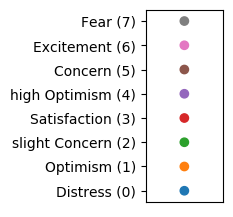

In [ ]:
# Show colors x emotions table:
x = np.zeros(n_emotions)
y = np.arange(n_emotions)

fig = plt.figure(figsize=(1, 2.5))
ax1 = plt.axes()

palette = 'tab10'
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap(palette).colors[:n_emotions])
ax1.axes.get_xaxis().set_visible(False)

plt.yticks(ticks=y, labels=[f"{emotional_attribution[i]} ({i})" for i in range(n_emotions)])
plt.scatter(x, y, c=y, cmap=cmap)

In [17]:
# Arrange all samples in a single dataframe.
df_ab_rates_single_col = rearrange_samples_from_a_b_tests(df_a_rates_single_col, df_b_rates_single_col, vid_to_emotion)
df_ab_rates_single_col

,index,test_ab,video,emotion,rater,test,dimension,rating
0,0,A,A01,0,Rater A01,(A01) Placer,Placer,1
1,1,A,A01,0,Rater A01,(A01) Activación,Activación,7
2,2,A,A01,0,Rater A01,(A01) Dominancia,Dominancia,2
3,3,A,A02,0,Rater A01,(A02) Placer,Placer,1
4,4,A,A02,0,Rater A01,(A02) Activación,Activación,9
...,...,...,...,...,...,...,...,...
6907,3163,B,B23,7,Rater B44,(B23) Activación,Activación,7
6908,3164,B,B23,7,Rater B44,(B23) Dominancia,Dominancia,6
6909,3165,B,B24,7,Rater B44,(B24) Placer,Placer,5
6910,3166,B,B24,7,Rater B44,(B24) Activación,Activación,5


3D representation of each data point

In [18]:
df_3d = pd.DataFrame({
    'pleasure': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Placer']['rating']),
    'arousal': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Activación']['rating']),
    'dominance': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Dominancia']['rating']),
    'emotion': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Placer']['emotion']),
    'video': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Placer']['video']),
    'test_ab': list(df_ab_rates_single_col[df_ab_rates_single_col['dimension'] == 'Placer']['test_ab']),
})
df_3d  # <n raters> x <24 videos> = ... triple-rate rows

,pleasure,arousal,dominance,emotion,video,test_ab
0,1,7,2,0,A01,A
1,1,9,1,0,A02,A
2,5,5,5,0,A03,A
3,8,6,7,1,A04,A
4,8,6,9,1,A05,A
...,...,...,...,...,...,...
2299,7,5,5,6,B20,B
2300,4,7,2,6,B21,B
2301,2,8,2,7,B22,B
2302,4,7,6,7,B23,B


#### Emotion of each video (1 point = 1 video)
Representations in space of the average PAD by video.

In [19]:
vid_names = [f"A{i+1:02}" for i in range(n_tests)] + [f"B{i+1:02}" for i in range(n_tests)]  # 'A01', 'A02', ...,'A24', 'B01'...'B24'

In [20]:
# Calculate the mean and stdev P, A and D across raters for each video in the test.
vid_pleasure_means = [np.mean(df_3d[df_3d['video'] == v]['pleasure']) for v in vid_names]
vid_pleasure_stds = [np.std(df_3d[df_3d['video'] == v]['pleasure'], ddof=1) for v in vid_names]
vid_arousal_means = [np.mean(df_3d[df_3d['video'] == v]['arousal']) for v in vid_names]
vid_arousal_stds = [np.std(df_3d[df_3d['video'] == v]['arousal'], ddof=1) for v in vid_names]
vid_dominance_means = [np.mean(df_3d[df_3d['video'] == v]['dominance']) for v in vid_names]
vid_dominance_stds = [np.std(df_3d[df_3d['video'] == v]['dominance'], ddof=1) for v in vid_names]

# List the hypothetical emotions attributed to each video.
vid_emotions = [vid_to_emotion.loc[v]['emotion'] for v in vid_names]

In [21]:
# Create a DataFrame with PAD values for each video.
df_video_pad = pd.DataFrame({
    'vid_name': vid_names,
    'vid_emotion': vid_emotions,
    'vid_pleasure_mean': vid_pleasure_means,
    'vid_pleasure_std': vid_pleasure_stds,
    'vid_arousal_mean': vid_arousal_means,
    'vid_arousal_std': vid_arousal_stds,
    'vid_dominance_mean': vid_dominance_means,
    'vid_dominance_std': vid_dominance_stds
})
print (len(df_video_pad))
df_video_pad.head()

# Save the DataFrame to a CSV file.
output_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs', 'pad_values_of_videos.csv')
df_video_pad.to_csv(output_path, index=False)

48


2D & 3D animated representation of each data point

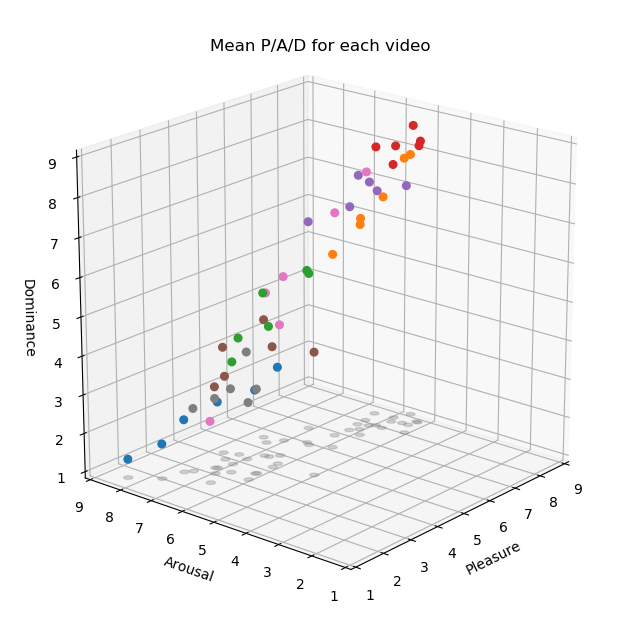

In [22]:
# These are matplotlib's Qualitative color palettes:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
palette = 'tab10'
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap(palette).colors[:n_emotions])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(vid_pleasure_means, vid_arousal_means, vid_dominance_means, s=30, alpha=1.0, c=vid_emotions, cmap=cmap)

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
ax.set_title('Mean P/A/D for each video')

for i in range(len(vid_pleasure_means)):
    p = Circle(
        (vid_pleasure_means[i], vid_arousal_means[i]), 0.11,  # Center and radius.
        color='grey', alpha=0.3
    )
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=1, zdir='z')

ax.set_xlim(left=1, right=9)
ax.set_ylim(bottom=1, top=9)
ax.set_zlim(bottom=1, top=9)

# Set the desired viewing angle
ax.view_init(elev=20, azim=220)  # Adjust the elevation (elev) and azimuth (azim) angles

plt.show()

In [23]:
def rotate(angle):
     ax.view_init(azim=angle)

anim_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs', 'test_3d_anim_all_videos_vs_emotion_test_AB.gif')
angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save(anim_name, writer=animation.PillowWriter(fps=20))

Result

<img src="../data/new_runs/test_3d_anim_all_videos_vs_emotion_test_AB.gif" alt="drawing" width="600"/>

#### PAD values for each emotion (1 point = 1 emotion)
Representations in space of the average of data points by emotion.

In [27]:
# Calculate the mean P, A and D across raters for each hypothetical emotion in the test.
emo_pleasure_means = [np.mean(df_3d[df_3d['emotion'] == e]['pleasure']) for e in range(n_emotions)]
emo_pleasure_stds = [np.std(df_3d[df_3d['emotion'] == e]['pleasure'], ddof=1) for e in range(n_emotions)]
emo_arousal_means = [np.mean(df_3d[df_3d['emotion'] == e]['arousal']) for e in range(n_emotions)]
emo_arousal_stds = [np.std(df_3d[df_3d['emotion'] == e]['arousal'], ddof=1) for e in range(n_emotions)]
emo_dominance_means = [np.mean(df_3d[df_3d['emotion'] == e]['dominance']) for e in range(n_emotions)]
emo_dominance_stds = [np.std(df_3d[df_3d['emotion'] == e]['dominance'], ddof=1) for e in range(n_emotions)]

In [28]:
emo_stats_df = pd.DataFrame({
    'emotion': np.arange(n_emotions),
    'name': [emotional_attribution[i] for i in range(n_emotions)],
    'pleasure (mean)': emo_pleasure_means,
    'pleasure (stdev)': emo_pleasure_stds,
    'arousal (mean)': emo_arousal_means,
    'arousal (stdev)': emo_arousal_stds,
    'dominance (mean)': emo_dominance_means,
    'dominance (stdev)': emo_dominance_stds,
})
emo_stats_df.set_index('emotion', inplace=True)
emo_stats_df

,name,pleasure (mean),pleasure (stdev),arousal (mean),arousal (stdev),dominance (mean),dominance (stdev)
emotion,,,,,,,
0,Distress,2.614583,1.827222,6.954861,2.227804,2.500000,1.627293
1,Optimism,7.378472,1.669303,5.468750,2.186209,7.100694,1.859227
2,slight Concern,4.722222,1.822983,6.649306,1.838023,4.642361,1.864918
3,Satisfaction,8.427083,1.066547,5.486111,2.571585,8.218750,1.360491
4,high Optimism,7.336806,1.749395,5.850694,2.245072,7.184028,1.969494
5,Concern,3.843750,1.851611,6.437500,2.107623,3.833333,1.991270
6,Excitement,5.288194,2.329241,6.437500,2.059122,5.291667,2.404627
7,Fear,3.156250,1.704645,6.447917,2.091312,3.149306,1.721538


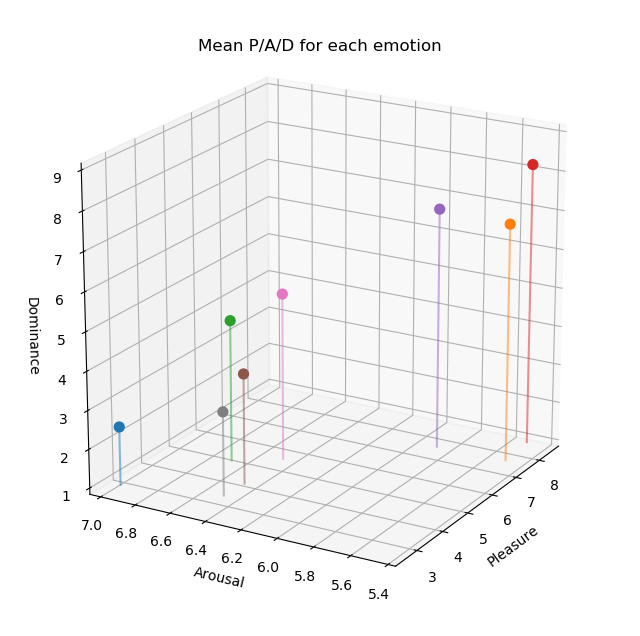

In [29]:
# These are matplotlib's Qualitative color palettes:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
palette = 'tab10'
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap(palette).colors[:n_emotions])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(emo_pleasure_means, emo_arousal_means, emo_dominance_means, s=50, alpha=1.0, c=np.arange(n_emotions), cmap=cmap)

for i in range(len(emo_pleasure_means)):
    ax.plot(
        [emo_pleasure_means[i], emo_pleasure_means[i]],
        [emo_arousal_means[i], emo_arousal_means[i]],
        [1, emo_dominance_means[i]],
        color=cmap.colors[i], alpha=0.5
    )

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
ax.set_title('Mean P/A/D for each emotion')

# ax.set_xlim(left=1, right=9)
# ax.set_ylim(bottom=1, top=9)
ax.set_zlim(bottom=1, top=9)

# Set the desired viewing angle
ax.view_init(elev=20, azim=210)  # Adjust the elevation (elev) and azimuth (azim) angles

plt.show()

In [30]:
def rotate(angle):
     ax.view_init(azim=angle)

anim_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'new_runs', 'test_3d_anim_all_emotions_dimensions_test_AB.gif')
angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save(anim_name, writer=animation.PillowWriter(fps=20))

Result

<img src="../data/new_runs/test_3d_anim_all_emotions_dimensions_test_AB.gif" alt="drawing" width="600"/>

### 4. Analyze the values obtained for Pleasure / Arousal / Dominance on each emotion.

#### Correlations among PAD for all data points

In [34]:
pg.pairwise_corr(df_3d[['pleasure', 'arousal', 'dominance']])  # Pearson pairwise correlation

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,pleasure,arousal,pearson,two-sided,2304,-0.187508,"[-0.23, -0.15]",1.125364e-19,1.962e+16,1.0
1,pleasure,dominance,pearson,two-sided,2304,0.865263,"[0.85, 0.88]",0.000000e+00,inf,1.0
2,arousal,dominance,pearson,two-sided,2304,-0.182182,"[-0.22, -0.14]",1.209051e-18,1.882e+15,1.0


#### Correlations among PAD for all videos

In [35]:
pg.pairwise_corr(
    pd.DataFrame({
        'pleasure': vid_pleasure_means,
        'arousal': vid_arousal_means,
        'dominance': vid_dominance_means,
    })
)  # Pearson pairwise correlation

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,pleasure,arousal,pearson,two-sided,48,-0.693290,"[-0.82, -0.51]",4.715668e-08,3.424e+05,0.999933
1,pleasure,dominance,pearson,two-sided,48,0.994360,"[0.99, 1.0]",1.758086e-46,1.492e+42,1.000000
2,arousal,dominance,pearson,two-sided,48,-0.688291,"[-0.81, -0.5]",6.432830e-08,2.559e+05,0.999913


Text(0, 0.5, 'Arousal')

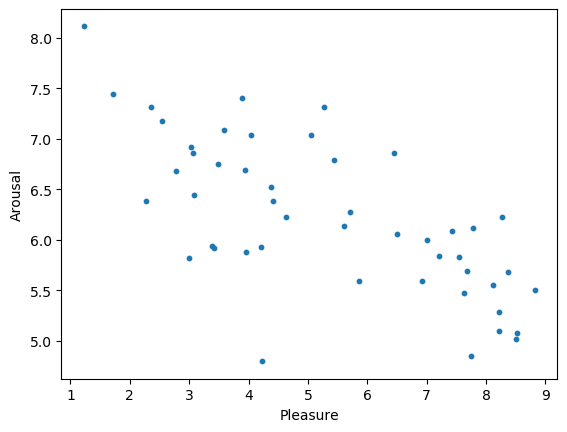

In [36]:
# Plot Pleasure vs Arousal:
plt.scatter(vid_pleasure_means, vid_arousal_means, s=10, alpha=1)
plt.xlabel('Pleasure')
plt.ylabel('Arousal')

Text(0, 0.5, 'Dominance')

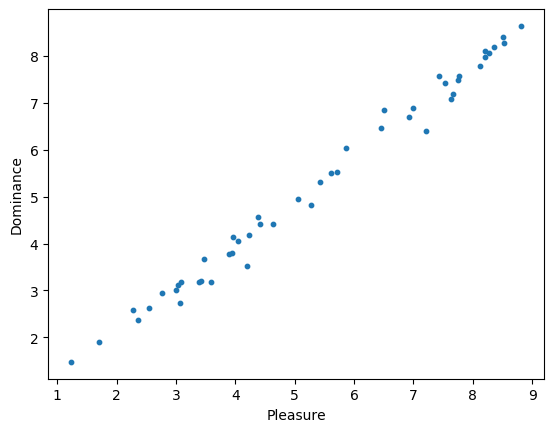

In [37]:
# Plot Pleasure vs Dominance:
plt.scatter(vid_pleasure_means, vid_dominance_means, s=10, alpha=1)
plt.xlabel('Pleasure')
plt.ylabel('Dominance')

Text(0, 0.5, 'Dominance')

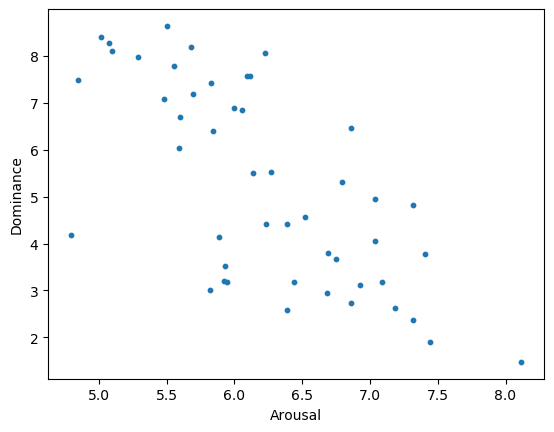

In [38]:
# Plot Arousal vs Dominance:
plt.scatter(vid_arousal_means, vid_dominance_means, s=10, alpha=1)
plt.xlabel('Arousal')
plt.ylabel('Dominance')

#### Correlations among PAD for all emotions

In [39]:
pg.pairwise_corr(
    pd.DataFrame({
        'pleasure': emo_pleasure_means,
        'arousal': emo_arousal_means,
        'dominance': emo_dominance_means,
    })
)  # Pearson pairwise correlation

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,pleasure,arousal,pearson,two-sided,8,-0.922272,"[-0.99, -0.62]",1.106621e-03,33.71,0.961207
1,pleasure,dominance,pearson,two-sided,8,0.999416,"[1.0, 1.0]",4.987303e-10,6.819e+05,1.000000
2,arousal,dominance,pearson,two-sided,8,-0.917867,"[-0.99, -0.6]",1.301206e-03,30.062,0.955431


Text(0, 0.5, 'Arousal')

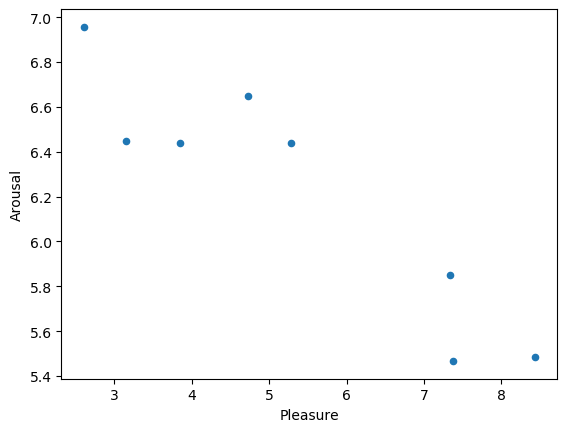

In [40]:
# Plot Pleasure vs Arousal:
plt.scatter(emo_pleasure_means, emo_arousal_means, s=20, alpha=1)
plt.xlabel('Pleasure')
plt.ylabel('Arousal')

Text(0, 0.5, 'Dominance')

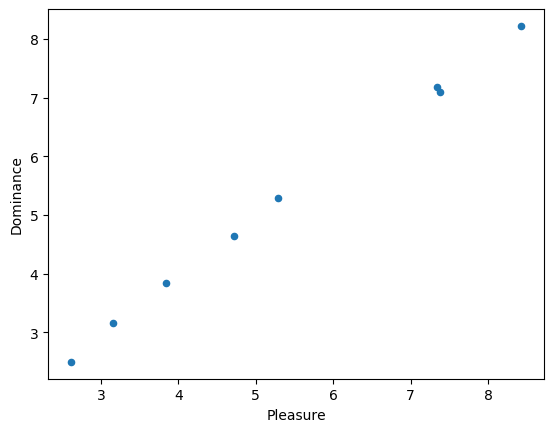

In [41]:
# Plot Pleasure vs Dominance:
plt.scatter(emo_pleasure_means, emo_dominance_means, s=20, alpha=1)
plt.xlabel('Pleasure')
plt.ylabel('Dominance')

Text(0, 0.5, 'Dominance')

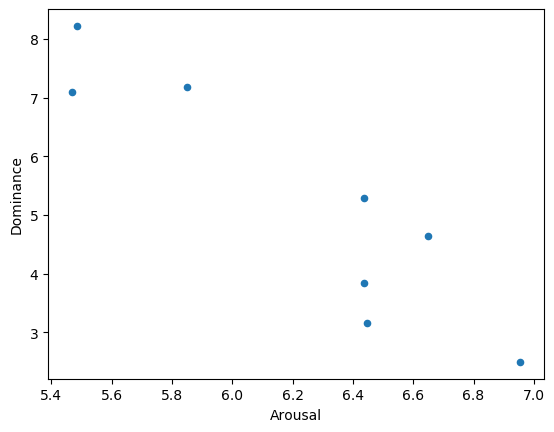

In [42]:
# Plot Arousal vs Dominance:
plt.scatter(emo_arousal_means, emo_dominance_means, s=20, alpha=1)
plt.xlabel('Arousal')
plt.ylabel('Dominance')

#### Distinguishability of the emotion PAD values

In [43]:
# Calculate Hotelling T-squared test (= multivariate T-test) for each pair of emotions across all data points.
multivar_ttest = np.zeros([n_emotions, n_emotions])
multivar_ttest[:] = np.nan

for emo1 in range(n_emotions):
    for emo2 in range(0, emo1, 1):
        mv_ttest = pg.multivariate_ttest(
            np.array(df_3d[df_3d['emotion'] == emo1][['pleasure', 'arousal', 'dominance']]),
            np.array(df_3d[df_3d['emotion'] == emo2][['pleasure', 'arousal', 'dominance']]),
        )
        multivar_ttest[emo1, emo2] = float(mv_ttest['pval'].iloc[0])

multivar_ttest_df = pd.DataFrame(multivar_ttest)
multivar_ttest_df

,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.663554e-143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.033336e-44,4.320217e-65,NaN,NaN,NaN,NaN,NaN,NaN
3,9.064668e-211,1.037083e-17,1.906671e-123,NaN,NaN,NaN,NaN,NaN
4,3.341631e-135,1.161902e-01,6.788755e-58,8.627224e-17,NaN,NaN,NaN,NaN
5,4.705928e-18,1.831517e-92,4.693267e-08,2.451758e-155,8.906829e-86,NaN,NaN,NaN
6,1.141574e-49,1.364904e-33,2.125553e-03,1.617304e-71,1.227084e-28,3.482231e-15,NaN,NaN
7,4.459782e-06,2.373908e-127,1.300688e-25,1.571769e-197,1.292886e-118,1.387915e-05,4.343177e-33,NaN


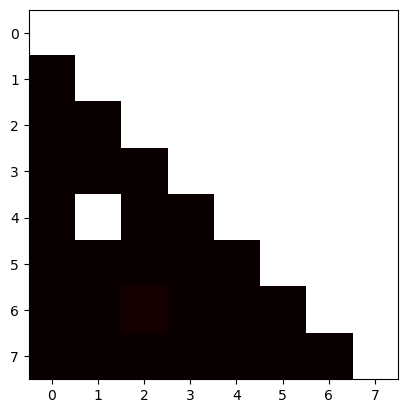

In [44]:
plt.imshow(multivar_ttest, cmap='hot')
plt.xticks(np.arange(n_emotions))
plt.show()

Results (high values mean overlapping distributions)

In [45]:
# The distribution of emotions 4 and 1 are less distinguishable ('highOptimism' and 'Optimism').
multivar_ttest[4, 1]

0.11619024822609848

## II. Mapping PAD values to referenced PAD values

### References and methodology overview

Comparison of the PAD values attributed to each learned emotion with referential experimental accounts from psychology:

* Russell, J.A., Mehrabian, A.: Evidence for a three-factor theory of emotions. J. Res. Personal. 11,
273–294 (1977)
* Bradley, M.M., Lang, P.J.: Affective norms for english words (ANEW): Instruction manual and affective ratings. Technical Report C-1, Center for Research in Psychophysiology, University of Florida (1999)
* Redondo, J., Fraga, I., Padrón, I., Comesaña, M.: The spanish adaptation of anew (affective norms for english words). Behavior Research Methods 39(3), 600–605 (2007)
* Landowska, A.: Towards new mappings between emotion representation models. Applied Sciences 8(2), 274 (2018)
* Scott, G.G., Keitel, A., Becirspahic, M., et al.: The glasgow norms: Ratings of 5,500 words on nine scales. Behavior Research Methods 51, 1258–1270 (2019)


Methodology:
1. For each of the learned emotions (0, 1, ... 7), obtain its separate PAD samples from the survey data. That will make 'Sample 1'.
2. Compare the distribution of 'Sample 1' with each of the distributions reported (N, mean of each PAD dim., std.dev of each PAD dim.) as 'Sample 2'. Statistical test = Hotelling T-squared (a multivariate extension of the t-test to compare the distribution of two multivariate samples) making assumptions about Sample 2's unknown covariance matrix.
3. For this agent’s task (short life-or-death landing maneuvers), ignore:

    - off-scope emotions: emotions associated with social relationships (*unfaithful, loyal, insolent, admired*), moral judgements (*dignity, paranoid, emotional*) or self-conscious reflections (*guilty, kind, repentant, lonely*);
    - redundant or vague terms (*achievement* and *achieved*, *frightened* and *fright*);
    - bodily needs (*hungry*);
    - non-emotions (*butter, cemetery, chair*).

### Prepare data from the test
2,304 datapoint & 8 emotions
* df_3d, emo_stats_df (original [1, 9] scale).
* df_3d_norm, emo_stats_df_norm (normalized to [-1, 1] scale).

In [46]:
path_to_pad_references = os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', 'survey', 'pad_reference_data')

In [47]:
emo_stats_df  # Statistics of PAD values in 1-9 scale (8 emotions)

,name,pleasure (mean),pleasure (stdev),arousal (mean),arousal (stdev),dominance (mean),dominance (stdev)
emotion,,,,,,,
0,Distress,2.614583,1.827222,6.954861,2.227804,2.500000,1.627293
1,Optimism,7.378472,1.669303,5.468750,2.186209,7.100694,1.859227
2,slight Concern,4.722222,1.822983,6.649306,1.838023,4.642361,1.864918
3,Satisfaction,8.427083,1.066547,5.486111,2.571585,8.218750,1.360491
4,high Optimism,7.336806,1.749395,5.850694,2.245072,7.184028,1.969494
5,Concern,3.843750,1.851611,6.437500,2.107623,3.833333,1.991270
6,Excitement,5.288194,2.329241,6.437500,2.059122,5.291667,2.404627
7,Fear,3.156250,1.704645,6.447917,2.091312,3.149306,1.721538


Normalization of data points and statistics to [-1, 1] scale.

In [48]:
df_3d_norm = df_3d.copy()
for e in ('pleasure', 'arousal', 'dominance'):
    df_3d_norm[e] = (df_3d_norm[e] - 5) / 4
df_3d_norm

,pleasure,arousal,dominance,emotion,video,test_ab
0,-1.00,0.50,-0.75,0,A01,A
1,-1.00,1.00,-1.00,0,A02,A
2,0.00,0.00,0.00,0,A03,A
3,0.75,0.25,0.50,1,A04,A
4,0.75,0.25,1.00,1,A05,A
...,...,...,...,...,...,...
2299,0.50,0.00,0.00,6,B20,B
2300,-0.25,0.50,-0.75,6,B21,B
2301,-0.75,0.75,-0.75,7,B22,B
2302,-0.25,0.50,0.25,7,B23,B


In [49]:
# Calculate the mean P, A and D across raters for each hypothetical emotion in the test.
emo_pleasure_means_norm = [np.mean(df_3d_norm[df_3d_norm['emotion'] == e]['pleasure']) for e in range(n_emotions)]
emo_pleasure_stds_norm = [np.std(df_3d_norm[df_3d_norm['emotion'] == e]['pleasure'], ddof=1) for e in range(n_emotions)]
emo_arousal_means_norm = [np.mean(df_3d_norm[df_3d_norm['emotion'] == e]['arousal']) for e in range(n_emotions)]
emo_arousal_stds_norm = [np.std(df_3d_norm[df_3d_norm['emotion'] == e]['arousal'], ddof=1) for e in range(n_emotions)]
emo_dominance_means_norm = [np.mean(df_3d_norm[df_3d_norm['emotion'] == e]['dominance']) for e in range(n_emotions)]
emo_dominance_stds_norm = [np.std(df_3d_norm[df_3d_norm['emotion'] == e]['dominance'], ddof=1) for e in range(n_emotions)]

In [50]:
emo_stats_df_norm = pd.DataFrame({
    'emotion': np.arange(n_emotions),
    'name': [emotional_attribution[i] for i in range(n_emotions)],
    'pleasure (mean)': emo_pleasure_means_norm,
    'pleasure (stdev)': emo_pleasure_stds_norm,
    'arousal (mean)': emo_arousal_means_norm,
    'arousal (stdev)': emo_arousal_stds_norm,
    'dominance (mean)': emo_dominance_means_norm,
    'dominance (stdev)': emo_dominance_stds_norm,
})
emo_stats_df_norm.set_index('emotion', inplace=True)
emo_stats_df_norm

,name,pleasure (mean),pleasure (stdev),arousal (mean),arousal (stdev),dominance (mean),dominance (stdev)
emotion,,,,,,,
0,Distress,-0.596354,0.456806,0.488715,0.556951,-0.625000,0.406823
1,Optimism,0.594618,0.417326,0.117188,0.546552,0.525174,0.464807
2,slight Concern,-0.069444,0.455746,0.412326,0.459506,-0.089410,0.466230
3,Satisfaction,0.856771,0.266637,0.121528,0.642896,0.804688,0.340123
4,high Optimism,0.584201,0.437349,0.212674,0.561268,0.546007,0.492374
5,Concern,-0.289062,0.462903,0.359375,0.526906,-0.291667,0.497818
6,Excitement,0.072049,0.582310,0.359375,0.514780,0.072917,0.601157
7,Fear,-0.460938,0.426161,0.361979,0.522828,-0.462674,0.430384


### Reference 1: Russell and Mehrabian (1977)


Russell, J.A., Mehrabian, A.: Evidence for a three-factor theory of emotions. J. Res. Personal. 11,273–294 (1977)

In this pivotal study, 151 different terms denoting emotional states were rated according to the three PAD values. The study reports the mean and standard deviation values for each, along with the number of samples.

The dataset, obtained from the original paper, is included in this repository for reproducibility purposes, for which author's permission was granted. Further use of these data for other purposes may require additional persmission from the authors.

####  Read Russell-Mehrabian PAD values


In [51]:
rm_pad_df = pd.read_csv(os.path.join(path_to_pad_references, 'PAD_values_Russell_Mehrabian_1977.csv'))
rm_pad_df

,Number,Term,N,Pleasure-mean,Pleasure-sd,Arousal-mean,Arousal-sd,Dominance-mean,Dominance-sd
0,1,Bold,27,0.44,0.32,0.61,0.24,0.66,0.30
1,2,Useful,27,0.70,0.20,0.44,0.28,0.47,0.40
2,3,Mighty,27,0.48,0.37,0.51,0.28,0.69,0.31
3,4,Kind,27,0.73,0.22,0.19,0.32,0.57,0.27
4,5,Self-satisfied,27,0.86,0.10,0.20,0.40,0.62,0.31
...,...,...,...,...,...,...,...,...,...
146,147,Uninterested,30,-0.47,0.26,-0.50,0.22,-0.08,0.24
147,148,Detached,30,-0.37,0.34,-0.26,0.28,-0.14,0.29
148,149,Discontented,30,-0.53,0.19,-0.16,0.41,-0.26,0.30
149,150,Discouraged,30,-0.61,0.25,-0.15,0.32,-0.29,0.32


#### Method 1: Hotelling T-squared - Sample 2's covariance assumption: independent vars.

In [52]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Russell-Mehrabian PAD data...")

rm_statistics_df = st.match_sample_vs_rm_pad_values(emotion_to_match, df_3d_norm, rm_pad_df)
rm_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs Russell-Mehrabian PAD data...


,rm_idx,rm_term,statistic
0,103,Helpless,3.698365
1,100,Fearful,5.234994
2,97,Insecure,5.793690
3,98,Humiliated,6.157902
4,112,Pain,7.144085
5,96,Distressed,7.485591
6,117,Guilty,7.572980
7,120,Confused,7.852914
8,104,Troubled,8.074359
9,95,Frustrated,8.129714


Top 3: Helpless, Fearful, Insecure

#### Method 2: Hotelling T-squared - Sample 2's covariance assumption: = Sample 1's.

In [53]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Russell-Mehrabian PAD data...")

rm_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, rm_pad_df,
    method='same'
)
rm_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs Russell-Mehrabian PAD data...


,rm_idx,rm_term,statistic
0,103,Helpless,3.733884
1,100,Fearful,5.285386
2,97,Insecure,5.728299
3,98,Humiliated,6.207736
4,112,Pain,7.129982
5,96,Distressed,7.220849
6,117,Guilty,7.478089
7,120,Confused,7.707590
8,104,Troubled,7.808646
9,101,Terrified,8.123117


Top 3: Helpless, Fearful, Insecure

#### Method 3: Hotelling T-squared - Euclidean distance (compare the means).

In [54]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Russell-Mehrabian PAD data...")

rm_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, rm_pad_df,
    method='means'
)
rm_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs Russell-Mehrabian PAD data...


,rm_idx,rm_term,statistic
0,103,Helpless,0.175676
1,100,Fearful,0.228723
2,98,Humiliated,0.254174
3,95,Frustrated,0.280194
4,112,Pain,0.296123
5,96,Distressed,0.337599
6,117,Guilty,0.354234
7,120,Confused,0.381135
8,101,Terrified,0.385141
9,104,Troubled,0.399763


Top 3: Helpless, Fearful, Frustrated

Off scope: Humiliated

### Reference 2: ANEW, by Bradley & Lang (1977)


Bradley, M.M., Lang, P.J.: Affective norms for english words (ANEW): Instruction manual and affective ratings. Technical Report C-1, Center for Research in Psychophysiology, University of Florida (1999)

A lexicon of 1,034 frequent words "developed to provide a set of normative emotional ratings for a large number of words in the English language".

Unfortunately, the dataset permissions exclude their placement on the internet, so only the first two rows have been left in this repository for orientative purposes, while preserving here the analytical results obtained from the full data.
The authors provide a link to request permission at: https://csea.phhp.ufl.edu/media/anewmessage.html

####  Read ANEW PAD values


In [55]:
anew_pad_df = pd.read_csv(os.path.join(path_to_pad_references, 'PAD_values_ANEW_sample.csv'))
anew_pad_df

,Description,Word No.,Valence Mean,Valence SD,Arousal Mean,Arousal SD,Dominance Mean,Dominance SD,Word Frequency
0,abduction,621,2.76,2.06,5.53,2.43,3.49,2.38,1
1,abortion,622,3.50,2.30,5.39,2.80,4.59,2.54,6
2,absurd,623,4.26,1.82,4.36,2.20,4.73,1.72,17
3,abundance,624,6.59,2.01,5.51,2.63,5.80,2.16,13
4,abuse,1,1.80,1.23,6.83,2.70,3.69,2.94,18
...,...,...,...,...,...,...,...,...,...
1029,yacht,1037,6.95,1.79,5.61,2.72,6.10,2.13,4
1030,yellow,545,5.61,1.94,4.43,2.05,5.47,1.58,55
1031,young,1038,6.89,2.12,5.64,2.51,5.30,2.49,385
1032,youth,1039,6.75,2.29,5.67,2.52,5.11,2.55,82


In [56]:
# Adapt data to process (column names and scale):
anew_pad_df_norm = pd.DataFrame()
anew_pad_df_norm['Term'] = anew_pad_df['Description']
# N is an undocumented value in dataset.

# Adapt to [-1, 1] scale.
anew_pad_df_norm['Pleasure-mean'] = anew_pad_df['Valence Mean']/4 - 1.25
anew_pad_df_norm['Pleasure-sd'] = anew_pad_df['Valence SD']/4

anew_pad_df_norm['Arousal-mean'] = anew_pad_df['Arousal Mean']/4 - 1.25
anew_pad_df_norm['Arousal-sd'] = anew_pad_df['Arousal SD']/4

anew_pad_df_norm['Dominance-mean'] = anew_pad_df['Dominance Mean']/4 - 1.25
anew_pad_df_norm['Dominance-sd'] = anew_pad_df['Dominance SD']/4

anew_pad_df_norm

,Term,Pleasure-mean,Pleasure-sd,Arousal-mean,Arousal-sd,Dominance-mean,Dominance-sd
0,abduction,-0.5600,0.5150,0.1325,0.6075,-0.3775,0.5950
1,abortion,-0.3750,0.5750,0.0975,0.7000,-0.1025,0.6350
2,absurd,-0.1850,0.4550,-0.1600,0.5500,-0.0675,0.4300
3,abundance,0.3975,0.5025,0.1275,0.6575,0.2000,0.5400
4,abuse,-0.8000,0.3075,0.4575,0.6750,-0.3275,0.7350
...,...,...,...,...,...,...,...
1029,yacht,0.4875,0.4475,0.1525,0.6800,0.2750,0.5325
1030,yellow,0.1525,0.4850,-0.1425,0.5125,0.1175,0.3950
1031,young,0.4725,0.5300,0.1600,0.6275,0.0750,0.6225
1032,youth,0.4375,0.5725,0.1675,0.6300,0.0275,0.6375


#### Method 1: Hotelling T-squared - Sample 2's covariance assumption: independent vars.

In [57]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW PAD data...")

anew_tls_statistics_df = st.match_sample_vs_rm_pad_values(emotion_to_match, df_3d_norm, anew_pad_df_norm)
anew_tls_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW PAD data...


,rm_idx,rm_term,statistic
0,808,scared,2.605335
1,901,surgery,4.309269
2,438,hostage,5.500752
3,325,fear,6.699121
4,448,hurricane,8.519073
5,676,panic,9.969456
6,445,humiliate,10.039632
7,35,ambulance,10.083964
8,393,guilty,10.459087
9,829,shark,11.801609


Top 3: scared, fear, panic

Non-emotions: surgery, hostage, hurricane

#### Method 2: Hotelling T-squared - Sample 2's covariance assumption: = Sample 1's.

In [58]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW PAD data...")

anew_tls_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, anew_pad_df_norm,
    method='same')
anew_tls_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW PAD data...


,rm_idx,rm_term,statistic
0,901,surgery,4.061015
1,808,scared,4.169270
2,448,hurricane,8.226641
3,676,panic,9.510779
4,445,humiliate,12.220827
5,292,embarrassed,12.472010
6,438,hostage,13.325588
7,551,lost,13.375994
8,325,fear,13.504699
9,340,flood,15.579705


Top 3: scared, panic, embarrassed

Non-emotions: surgery, hurricane

Off-scope: humiliate

#### Method 3: Hotelling T-squared - Euclidean distance (compare the means).

In [59]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW PAD data...")

anew_tls_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, anew_pad_df_norm,
    method='means')
anew_tls_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW PAD data...


,rm_idx,rm_term,statistic
0,808,scared,0.122257
1,438,hostage,0.141145
2,901,surgery,0.174747
3,325,fear,0.183639
4,35,ambulance,0.206160
5,676,panic,0.216461
6,277,drown,0.217968
7,948,trauma,0.219495
8,445,humiliate,0.225598
9,448,hurricane,0.232744


Top 3: scared, fear, panic

Non-emotion: hostage, surgery, ambulance

### Reference 3: Spanish ANEW, by Redondo et al (2007)


Redondo, J., Fraga, I., Padrón, I., Comesaña, M.: The spanish adaptation of anew (affective norms for english words). Behavior Research Methods 39(3), 600–605 (2007)

Mapping between the 1,034 Spanish ANEW words and PAD values (from Spanish speakers).

The original dataset can be accessed in the public link of the paper at Springer.com, section ["Electronic supplementary material"](https://link.springer.com/article/10.3758/BF03193031#rightslink:~:text=Supplementary%20material%2C%20approximately%20340%20KB). 


####  Read Spanish ANEW PAD values


In [60]:
sanew_pad_df = pd.read_csv(os.path.join(path_to_pad_references, 'PAD_values_Spanish_ANEW.csv'))
sanew_pad_df

,Number,E-Word,S-Word,Val-Mn-All,Val-Sd-All,Aro-Mn-All,Aro-Sd-All,Dom-Mn-All,Dom-Sd-All,Nlett,Nsyll,GClass,Freq,Neigh,Fam,Con,Imag
0,722,derelict,abandonado,1.68,1.00,5.88,2.21,3.11,2.03,10,5,V/A,27.86,1,UnAv,UnAv,UnAv
1,583,bees,abejas,3.18,1.85,6.59,2.05,3.42,2.32,6,3,N,0.00,0,UnAv,UnAv,UnAv
2,622,abortion,aborto,2.80,2.13,6.07,1.87,4.17,2.37,6,3,N,10.00,1,5.26,5.47,4.83
3,975,scorching,abrasador,2.46,1.58,6.00,2.16,4.00,2.19,9,4,A,0.71,0,UnAv,UnAv,UnAv
4,218,hug,abrazo,8.13,1.34,5.70,2.57,6.12,2.16,6,3,N,15.71,0,5.41,5.9,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,619,volcano,volcán,3.52,2.02,6.63,2.07,2.58,2.26,6,2,N,5.54,1,3.87,6.2,6.15
1030,481,vomit,vómito,1.76,1.16,5.80,2.54,3.12,2.15,6,3,N,3.04,1,UnAv,UnAv,UnAv
1031,1037,yacht,yate,6.57,1.81,5.19,2.23,5.49,1.92,4,2,N,9.64,7,3.57,5.95,6.32
1032,371,sapphire,zafiro,6.71,1.83,5.21,2.12,5.12,1.87,6,3,N,1.43,0,UnAv,UnAv,UnAv


In [61]:
# Rename and select columns.
sanew_pad_df = sanew_pad_df[['E-Word', 'Val-Mn-All', 'Val-Sd-All', 'Aro-Mn-All', 'Aro-Sd-All', 'Dom-Mn-All', 'Dom-Sd-All']].copy()
sanew_pad_df.rename(columns={
    'E-Word': 'Term',
    'Val-Mn-All': 'Pleasure-mean',
    'Val-Sd-All': 'Pleasure-sd',
    'Aro-Mn-All': 'Arousal-mean',
    'Aro-Sd-All': 'Arousal-sd',
    'Dom-Mn-All': 'Dominance-mean',
    'Dom-Sd-All': 'Dominance-sd',
}, inplace=True
)

# Adapt to [-1, 1] scale.
sanew_pad_df['Pleasure-mean'] = sanew_pad_df['Pleasure-mean']/4 - 1.25
sanew_pad_df['Pleasure-sd'] = sanew_pad_df['Pleasure-sd']/4

sanew_pad_df['Arousal-mean'] = sanew_pad_df['Arousal-mean']/4 - 1.25
sanew_pad_df['Arousal-sd'] = sanew_pad_df['Arousal-sd']/4

sanew_pad_df['Dominance-mean'] = sanew_pad_df['Dominance-mean']/4 - 1.25
sanew_pad_df['Dominance-sd'] = sanew_pad_df['Dominance-sd']/4

sanew_pad_df

,Term,Pleasure-mean,Pleasure-sd,Arousal-mean,Arousal-sd,Dominance-mean,Dominance-sd
0,derelict,-0.8300,0.2500,0.2200,0.5525,-0.4725,0.5075
1,bees,-0.4550,0.4625,0.3975,0.5125,-0.3950,0.5800
2,abortion,-0.5500,0.5325,0.2675,0.4675,-0.2075,0.5925
3,scorching,-0.6350,0.3950,0.2500,0.5400,-0.2500,0.5475
4,hug,0.7825,0.3350,0.1750,0.6425,0.2800,0.5400
...,...,...,...,...,...,...,...
1029,volcano,-0.3700,0.5050,0.4075,0.5175,-0.6050,0.5650
1030,vomit,-0.8100,0.2900,0.2000,0.6350,-0.4700,0.5375
1031,yacht,0.3925,0.4525,0.0475,0.5575,0.1225,0.4800
1032,sapphire,0.4275,0.4575,0.0525,0.5300,0.0300,0.4675


#### Method 1: Hotelling T-squared - Sample 2's covariance assumption: independent vars.

In [62]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Spanish ANEW PAD data...")

sanew_statistics_df = st.match_sample_vs_rm_pad_values(emotion_to_match, df_3d_norm, sanew_pad_df)
sanew_statistics_df[:15]

Match hypothetical emotion 0 (Distress) vs Spanish ANEW PAD data...


,rm_idx,rm_term,statistic
0,96,avalanche,1.112740
1,124,beast,2.048543
2,964,tornado,3.157791
3,504,hurricane,3.170539
4,787,python,5.990484
5,102,wasp,6.251874
6,91,robber,6.742385
7,366,scorpion,6.940294
8,163,chaos,7.215493
9,87,scared,8.409766


Top three: scared, insecure, lost

Non-emotions: avalanche, beast, tornado, hurricane, python, wasp, robber, scorpion, chaos, cliff, revolt

Off-scope: jealousy

#### Method 2: Hotelling T-squared - Sample 2's covariance assumption: = Sample 1's.

In [63]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Spanish ANEW PAD data...")

sanew_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, sanew_pad_df,
    method='same')
sanew_statistics_df[:17]

Match hypothetical emotion 0 (Distress) vs Spanish ANEW PAD data...


,rm_idx,rm_term,statistic
0,96,avalanche,1.023440
1,964,tornado,2.531220
2,124,beast,2.679740
3,504,hurricane,5.449177
4,91,robber,7.007544
5,864,revolt,8.420657
6,787,python,8.655445
7,689,nervous,9.874125
8,198,cyclone,10.058237
9,366,scorpion,10.512370


Top 3: nervous, lost, insecure

Non-emotions: avalanche, tornado, beast, hurricane, robber, revolt, python, cyclone, scorpion, chaos, nightmare

Off-scope: shy, obsession

#### Method 3: Hotelling T-squared - Euclidean distance (compare the means).

In [64]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Spanish ANEW PAD data...")

sanew_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, sanew_pad_df,
    method='means')
sanew_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs Spanish ANEW PAD data...


,rm_idx,rm_term,statistic
0,96,avalanche,0.072624
1,504,hurricane,0.103359
2,124,beast,0.105144
3,964,tornado,0.124858
4,163,chaos,0.156516
5,102,wasp,0.156725
6,89,terrified,0.172347
7,180,jealousy,0.174273
8,937,fear,0.177551
9,295,despairing,0.178435


Top 3: terrified, fear, despairing

Non-emotions: avalanche, hurricane, beast, tornado, chaos, wasp

Off-scope: jealousy

### Reference 4: ANEW_MEHR, by Landowska (2018)


Landowska, A.: Towards new mappings between emotion representation models. Applied Sciences 8(2), 274 (2018)

Assignment of the preexisting ANEW PAD values to 112 Russel-Mehrabian’s emotions (out of 151).

The original dataset is downloadable as a semicolon-separated .csv file [in the public link provided by the author](https://www.mdpi.com/2076-3417/8/2/274/s1).


####  Read ANEW_MEHR PAD values

In [65]:
anew_pad_df = pd.read_csv(os.path.join(path_to_pad_references, 'PAD_values_ANEW_MEHR.csv'))
anew_pad_df

,Term,P_anew,P_SD,A_anew,A_SD,D_anew,D_SD
0,Bold,0.4500,0.4025,0.1500,0.5525,0.4175,0.4525
1,Useful,0.5350,0.4000,-0.1850,0.6175,0.2325,0.5250
2,Mighty,0.3850,0.5475,0.1525,0.5950,0.5575,0.5275
3,Kind,0.6475,0.4175,-0.1350,0.6375,0.2375,0.4825
4,Admired,0.6850,0.4600,0.2775,0.5900,0.6325,0.4850
...,...,...,...,...,...,...,...
107,Listless,-0.2200,0.4325,-0.2250,0.5775,-0.2150,0.4325
108,Weary,-0.3025,0.5300,-0.2975,0.5725,-0.2500,0.4775
109,Detached,-0.2850,0.4700,-0.1850,0.6425,-0.3425,0.5375
110,Discouraged,-0.5000,0.5400,-0.1175,0.5275,-0.3475,0.5025


In [66]:
anew_pad_df.rename(columns={
    'P_anew': 'Pleasure-mean',
    'P_SD': 'Pleasure-sd',
    'A_anew': 'Arousal-mean',
    'A_SD': 'Arousal-sd',
    'D_anew': 'Dominance-mean',
    'D_SD': 'Dominance-sd',
}, inplace=True
)
anew_pad_df

,Term,Pleasure-mean,Pleasure-sd,Arousal-mean,Arousal-sd,Dominance-mean,Dominance-sd
0,Bold,0.4500,0.4025,0.1500,0.5525,0.4175,0.4525
1,Useful,0.5350,0.4000,-0.1850,0.6175,0.2325,0.5250
2,Mighty,0.3850,0.5475,0.1525,0.5950,0.5575,0.5275
3,Kind,0.6475,0.4175,-0.1350,0.6375,0.2375,0.4825
4,Admired,0.6850,0.4600,0.2775,0.5900,0.6325,0.4850
...,...,...,...,...,...,...,...
107,Listless,-0.2200,0.4325,-0.2250,0.5775,-0.2150,0.4325
108,Weary,-0.3025,0.5300,-0.2975,0.5725,-0.2500,0.4775
109,Detached,-0.2850,0.4700,-0.1850,0.6425,-0.3425,0.5375
110,Discouraged,-0.5000,0.5400,-0.1175,0.5275,-0.3475,0.5025


#### Method 1: Hotelling T-squared - Sample 2's covariance assumption: independent vars.

In [67]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW_MEHR PAD data...")

br_statistics_df = st.match_sample_vs_rm_pad_values(emotion_to_match, df_3d_norm, anew_pad_df)
br_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW_MEHR PAD data...


,rm_idx,rm_term,statistic
0,88,Guilty,10.459087
1,81,Embarrassed,12.197758
2,71,Insecure,20.439105
3,84,Pain,25.680109
4,75,Helpless,27.230186
5,68,Crushed,27.327148
6,90,Regretful,28.288259
7,69,Frustrated,28.934919
8,94,Despairing,29.170100
9,73,Fearful,30.310303


Top 3: Insecure, Pain, Helpless

Off-scope: Guilty, Embarrassed

#### Method 2: Hotelling T-squared - Sample 2's covariance assumption: = Sample 1's.

In [68]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW_MEHR PAD data...")

br_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, anew_pad_df,
    method='same')
br_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW_MEHR PAD data...


,rm_idx,rm_term,statistic
0,81,Embarrassed,12.472010
1,88,Guilty,17.159882
2,71,Insecure,22.197742
3,75,Helpless,31.561847
4,102,Rejected,46.611713
5,94,Despairing,47.333009
6,79,Shamed,49.553086
7,69,Frustrated,51.020288
8,83,Defeated,51.553852
9,90,Regretful,53.589039


Top 3: Insecure, Helpless, Despairing

Off-scope: Embarrassed, Guilty, Rejected

#### Method 3: Hotelling T-squared - Euclidean distance (compare the means).

In [69]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs ANEW_MEHR PAD data...")

br_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, anew_pad_df,
    method='means')
br_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs ANEW_MEHR PAD data...


,rm_idx,rm_term,statistic
0,88,Guilty,0.272180
1,81,Embarrassed,0.304794
2,102,Rejected,0.319449
3,73,Fearful,0.337544
4,84,Pain,0.345129
5,74,Terrified,0.349639
6,71,Insecure,0.357015
7,70,Distressed,0.383286
8,90,Regretful,0.391530
9,94,Despairing,0.397197


Top 3: Fearful, Pain, Terrified

Off-scope: Guilty, Embarrassed, Rejected

### Reference 5: Glasgow Norms, by Scott et al (2019)


Scott, G.G., Keitel, A., Becirspahic, M., et al.: The glasgow norms: Ratings of 5,500 words on nine scales. Behavior Research Methods 51, 1258–1270 (2019)

Ratings of 5,553 English words on nine scales (including PAD).

The original dataset can be accessed in the public link of the paper at Springer.com, section ["Electronic supplementary material"](https://link.springer.com/article/10.3758/s13428-018-1099-3#Sec13). 


####  Read Glasgow Norms PAD values


In [70]:
gn_pad_df = pd.read_csv(os.path.join(path_to_pad_references, 'PAD_values_Glasgow_norms.csv'))
gn_pad_df

,Words,Length,AROU_M,AROU_SD,AROU_N,VAL_M,VAL_SD,VAL_N,DOM_M,DOM_SD,...,AOA,SD.3,N.3,SIZE,SD.4,N.4,GEND,SD.5,N.5,N_AR_VA_DO
0,abattoir,8,4.200,2.400,25,2.864,1.740,22,4.333,1.285,...,6.760,0.427,25,4.652,1.549,23,5.391,1.170,23,21
1,abbey,5,3.125,2.342,32,5.781,1.268,32,4.667,1.551,...,5.177,1.339,34,5.121,1.629,33,3.303,1.193,33,32
2,abbreviate,10,3.273,1.582,33,5.250,1.031,32,5.235,1.238,...,5.543,1.130,35,2.667,1.700,33,3.971,0.954,34,32
3,abdicate,8,4.194,1.941,31,3.767,1.383,30,4.419,2.182,...,6.233,0.844,30,4.679,1.441,28,5.167,1.186,30,30
4,abdication,10,3.846,2.282,26,3.880,1.608,25,4.800,1.960,...,6.407,0.913,27,5.083,1.351,24,4.571,1.015,28,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,zeppelin,8,6.185,2.037,27,5.000,1.414,27,5.333,1.743,...,6.036,0.944,28,5.464,1.721,28,5.269,1.021,26,27
5549,zero,4,4.031,2.023,32,4.182,1.585,33,4.567,2.124,...,2.636,1.123,33,1.758,1.393,33,4.172,0.647,29,30
5550,zest,4,5.969,2.158,32,6.818,1.313,33,6.121,1.320,...,5.364,1.123,33,2.636,1.738,33,3.452,1.011,31,32
5551,zoo,3,5.909,2.137,33,6.235,1.800,34,5.485,1.598,...,2.324,0.674,34,4.844,1.873,32,4.059,0.802,34,33


In [71]:
# Adapt Glasgow Norms data to process (column names and scale):
gn_pad_df_norm = pd.DataFrame()
gn_pad_df_norm['Term'] = gn_pad_df['Words']
gn_pad_df_norm['N'] = gn_pad_df['N_AR_VA_DO']

# Adapt to [-1, 1] scale.
gn_pad_df_norm['Pleasure-mean'] = gn_pad_df['VAL_M']/4 - 1.25
gn_pad_df_norm['Pleasure-sd'] = gn_pad_df['VAL_SD']/4

gn_pad_df_norm['Arousal-mean'] = gn_pad_df['AROU_M']/4 - 1.25
gn_pad_df_norm['Arousal-sd'] = gn_pad_df['AROU_SD']/4

gn_pad_df_norm['Dominance-mean'] = gn_pad_df['DOM_M']/4 - 1.25
gn_pad_df_norm['Dominance-sd'] = gn_pad_df['DOM_SD']/4

gn_pad_df_norm

,Term,N,Pleasure-mean,Pleasure-sd,Arousal-mean,Arousal-sd,Dominance-mean,Dominance-sd
0,abattoir,21,-0.53400,0.43500,-0.20000,0.60000,-0.16675,0.32125
1,abbey,32,0.19525,0.31700,-0.46875,0.58550,-0.08325,0.38775
2,abbreviate,32,0.06250,0.25775,-0.43175,0.39550,0.05875,0.30950
3,abdicate,30,-0.30825,0.34575,-0.20150,0.48525,-0.14525,0.54550
4,abdication,25,-0.28000,0.40200,-0.28850,0.57050,-0.05000,0.49000
...,...,...,...,...,...,...,...,...
5548,zeppelin,27,0.00000,0.35350,0.29625,0.50925,0.08325,0.43575
5549,zero,30,-0.20450,0.39625,-0.24225,0.50575,-0.10825,0.53100
5550,zest,32,0.45450,0.32825,0.24225,0.53950,0.28025,0.33000
5551,zoo,33,0.30875,0.45000,0.22725,0.53425,0.12125,0.39950


#### Method 1: Hotelling T-squared - Sample 2's covariance assumption: independent vars.

In [72]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Glasgow Norms PAD data...")

gn_statistics_df = st.match_sample_vs_rm_pad_values(emotion_to_match, df_3d_norm, gn_pad_df_norm)
gn_statistics_df[:15]

Match hypothetical emotion 0 (Distress) vs Glasgow Norms PAD data...


,rm_idx,rm_term,statistic
0,1856,fearful,1.373253
1,2030,frightened,1.568709
2,60,addicted,1.755871
3,2029,fright,2.156662
4,2631,jeopardy,2.743655
5,2529,infectious,2.913056
6,2940,madness,2.913573
7,26,abyss,3.279528
8,2547,insanity,3.449645
9,524,bonds (restraints),3.477017


Top 3: fearful, frightened, panic

Redundant: fright

Non-emotion: addicted, jeopardy, infectious, madness, abyss, insanity, bonds (restraints), prisoner

#### Method 2: Hotelling T-squared - Sample 2's covariance assumption: = Sample 1's.

In [73]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Glasgow Norms PAD data...")

gn_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, gn_pad_df_norm,
    method='same')
gn_statistics_df[:15]

Match hypothetical emotion 0 (Distress) vs Glasgow Norms PAD data...


,rm_idx,rm_term,statistic
0,1856,fearful,1.335195
1,2030,frightened,1.542863
2,60,addicted,1.756242
3,2029,fright,2.390863
4,2631,jeopardy,2.918126
5,2940,madness,3.130790
6,2529,infectious,3.133750
7,26,abyss,3.415521
8,524,bonds (restraints),3.481637
9,3803,prisoner,3.771720


Top 3: fearful, frightened, panic

Redundant: fright

Non-emotion: addicted, jeopardy, infectious, madness, abyss, insanity, bonds (restraints), prisoner

#### Method 3: Hotelling T-squared - Euclidean distance (compare the means).

In [74]:
emotion_to_match = 0  # Run for all the emotion numbers (0 to 7 in this use case).
print(f"Match hypothetical emotion {emotion_to_match} ({emotional_attribution[emotion_to_match]}) vs Glasgow Norms PAD data...")

gn_statistics_df = st.match_sample_vs_rm_pad_values(
    emotion_to_match, df_3d_norm, gn_pad_df_norm,
    method='means')
gn_statistics_df[:10]

Match hypothetical emotion 0 (Distress) vs Glasgow Norms PAD data...


,rm_idx,rm_term,statistic
0,1856,fearful,0.186359
1,2030,frightened,0.202815
2,60,addicted,0.223033
3,2029,fright,0.226475
4,2547,insanity,0.231770
5,1291,danger,0.235421
6,1706,epidemic,0.260645
7,2631,jeopardy,0.263747
8,2940,madness,0.264450
9,5094,tragedy,0.283671


Top 3: fearful, frightened, danger

Redundant: fright

Non-emotions: addicted, insanity